### Upstash Experimentation (for cache)

upstash lib docs: https://github.com/upstash/redis-py?tab=readme-ov-file#install

In [ ]:
import os
from dotenv import load_dotenv
from upstash_redis import Redis # pip install upstash-redis

load_dotenv()

UPSTASH_REDIS_REST_URL = os.getenv("UPSTASH_REDIS_REST_URL")
UPSTASH_REDIS_REST_TOKEN = os.getenv("UPSTASH_REDIS_REST_TOKEN")

redis = Redis(url=UPSTASH_REDIS_REST_URL, token=UPSTASH_REDIS_REST_TOKEN)

In [ ]:
import json 
import zlib
import base64

entry = {
    "video_id": "JRHwq1DIgbI",
    "channel": "Astrum",
    "category_id": 27,
    "published_at": "2024-06-12T16:17:50Z",
    "tags": "['astrum', 'astronomy', 'space', 'planets', 'solar system', 'stars', 'jupiter', 'space mission', 'Great Red Spot', 'jupiter mission', 'flyby', 'space images', 'sun', 'Earth', 'mars', 'saturn', 'ISS', 'barycentre', 'mercury', 'neptune', 'vesta', 'telescopes', 'Europa', 'planetary rings', 'red dwarf', 'magnetosphere', 'solar storm', 'aurorae', 'Jupiter’s moon', 'Io', 'Jovian moons', 'Galilean moons', 'Ganymede', 'callisto']",
    "view_count": 2467376,
    "like_count": 56950,
    "comment_count": 1600,
    "made_for_kids": False,
    "duration": "PT14M42S"
}

compressed_entry = zlib.compress(json.dumps(entry).encode('utf8'))
encoded_entry = base64.b64encode(compressed_entry).decode('utf8')
redis.set(entry['video_id'], encoded_entry)

In [ ]:
print("size (characters):", len(encoded_entry))

print("size (bytes):", len(encoded_entry.encode('utf-8')))

In [ ]:
decoded_bytes = base64.b64decode(redis.get("JRHwq1DIgbI"))
decompressed_data = zlib.decompress(decoded_bytes)
decoded_entry = json.loads(decompressed_data.decode('utf-8'))
print(decoded_entry)

### Personal Youtube Stats Testing

In [ ]:
# using orjson to parse larger json a bit faster

import re 
import orjson # pip install orjson
import pandas as pd
from dateutil import parser

# should be what you get from takeout
with open('watch-history.json', 'rb') as file:
    data = orjson.loads(file.read())

df = pd.DataFrame.from_records(data)
df = df[['titleUrl', 'time']].dropna(subset='titleUrl')
df.columns = ['url', 'time']


def extract_video_id(url):
    pattern = r'(?:v=|\/)([0-9A-Za-z_-]{11}).*'
    match = re.search(pattern, url)
    return match.group(1) if match else None

df['time'] = df['time'].apply(parser.parse)
df['vid_id'] =  df['url'].astype(str).apply(extract_video_id).to_list()

In [ ]:
# checking what the total size of this on disk will be
import io

buffer = io.StringIO()

df[['vid_id', 'time']].to_csv(buffer)

size_in_bytes = buffer.tell()
size_in_kb = size_in_bytes / 1024
print(f"Size of the file in KB: {size_in_kb:.2f}")

you'll need to create a project on gcp and activate the youtueb api for this to work. Also, try to use chrome as your browser for this since safari and firefox break the auth



In [ ]:
# Sample Python code for youtube.videos.list
# See instructions for running these code samples locally:
# https://developers.google.com/explorer-help/code-samples#python

import os

from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

os.environ.pop("OAUTHLIB_INSECURE_TRANSPORT", None)

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret.json"
token_path = "youtube_token.json"

creds: Credentials = None

if os.path.exists(token_path):
    creds = Credentials.from_authorized_user_file(token_path, scopes)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
            client_secrets_file, scopes
        )
        creds = flow.run_local_server(open_browser=False)
        with open(token_path, "w") as token_file:
            token_file.write(creds.to_json())

youtube_client = googleapiclient.discovery.build(
    api_service_name, api_version, credentials=creds
)

In [ ]:
import numpy as np

def batch(iterable, n=50):  # 50 is the max number of video ids that you can request from the api at once
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

    
video_id_batches = list(batch(df['vid_id'].to_numpy()))
video_id_batches:list[str] = [','.join(batch) for batch in video_id_batches]

check this out for an idea on how to pull data from the api, there should be some example runs you can do if you already have a project or even just have logged in with your email

https://developers.google.com/youtube/v3/docs/videos/list

In [ ]:
from collections import defaultdict
import pandas as pd

def get_video_metadata_batch(video_ids, youtube_client):
    def get_video_metadata_batch(video_ids, youtube_client):
        request = youtube_client.videos().list(
            part="snippet,statistics,contentDetails",
            id=video_ids,
            maxResults=50, 
            fields=(
                "items(id,"
                "snippet(channelTitle,categoryId,publishedAt,tags,defaultLanguage),"
                "statistics(viewCount,likeCount,commentCount),contentDetails/duration)"
            )
        )
        try:
            response = request.execute()
            return response.get('items', [])
        except Exception as e:
            print(f"Error fetching batch: {e}")
            return []

    # result get_video_metadata_batch(video_id_batches[0], youtube_client)
    # Process batches synchronously
    results = []

    for batch in video_id_batches:
        batch_results = get_video_metadata_batch(batch, youtube_client)
        results.extend(batch_results)
    try:
        response = request.execute()
        return response.get('items', [])
    except Exception as e:
        print(f"Error fetching batch: {e}")
        return []

# TODO: there is bug here where we aren't counting videos that might have multiple occurences in the the list of vids. Those still count for a lot so include them.

# resultget_video_metadata_batch(video_id_batches[0], youtube_client)
# Process batches synchronously
results = []
for batch in video_id_batches:
    batch_results = get_video_metadata_batch(batch, youtube_client)
    results.extend(batch_results)        

In [ ]:
video_data = defaultdict(list)
for item in results:
    if not item:
        continue
        
    snippet = item.get('snippet', {})
    statistics = item.get('statistics', {})
    
    video_data['video_id'].append(item['id'])
    video_data['channel'].append(snippet.get('channelTitle'))
    video_data['category_id'].append(snippet.get('categoryId'))
    video_data['published_at'].append(snippet.get('publishedAt'))
    video_data['tags'].append(snippet.get('tags', []))
    video_data['view_count'].append(int(statistics.get('viewCount', 0)))
    video_data['like_count'].append(int(statistics.get('likeCount', 0)))
    video_data['comment_count'].append(int(statistics.get('commentCount', 0)))
    video_data['made_for_kids'].append(item.get('status', {}).get('madeForKids', False))
    video_data['duration'].append(item.get('contentDetails', {}).get('duration'))

video_df = pd.DataFrame(video_data)
video_df.to_csv("video_metadata.csv")

request = youtube_client.videoCategories().list(
    part="snippet",
    regionCode="US"
)
response = request.execute()

In [ ]:
video_df = pd.read_csv('video_metadata.csv')
response_df = pd.json_normalize(response["items"])[['id', 'snippet.title']]
response_df.columns = ['id', 'category_title']
response_df['id'] = response_df['id'].astype(int)

video_df = pd.merge(video_df, response_df[['category_title']], left_on='category_id', right_on=response_df['id'])
video_df = video_df.drop(['Unnamed: 0'], axis=1)


video_df = pd.merge(video_df, df[['time']], left_on='video_id', right_on=df['vid_id'])
video_df['duration'] = pd.to_timedelta(video_df['duration'])

video_df.columns = ['video_id', 'channel', 'category_id', 'published_at', 'tags',
       'view_count', 'like_count', 'comment_count', 'made_for_kids',
       'duration', 'category_title', 'time_watched']

video_df.to_csv("video_metadata_full.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

total_watch_time = video_df['duration'].sum()
top_channels = video_df.groupby('channel')['duration'].sum().nlargest(10)
category_watch_time = video_df.groupby('category_title')['duration'].sum().nlargest(5)
most_liked = video_df.nlargest(10, 'like_count')[['video_id', 'channel', 'like_count']]
most_commented = video_df.nlargest(10, 'comment_count')[['video_id', 'channel', 'comment_count']]
most_popular_videos = video_df.nlargest(10, 'view_count')[['video_id', 'channel', 'view_count']]
longest_video = video_df.nlargest(1, 'duration')[['video_id', 'channel', 'duration']]

top_videos = video_df.nlargest(10, 'duration')[['video_id', 'channel', 'duration']]


video_df['hour_watched'] = video_df['time_watched'].dt.hour
video_df['date_watched'] = video_df['time_watched'].dt.date
night_watching = video_df[video_df['hour_watched'] >= 22]['duration'].sum()
morning_watching = video_df[video_df['hour_watched'] <= 6]['duration'].sum()


video_df['hour_watched'] = video_df['time_watched'].dt.hour
watch_by_hour = video_df.groupby('hour_watched')['duration'].sum()

video_df['date_watched'] = video_df['time_watched'].dt.date
streaks = video_df['date_watched'].value_counts().sort_index()
binge_creator = video_df.groupby('channel')['duration'].max().nlargest(1)

kids_percentage = video_df['made_for_kids'].mean() * 100

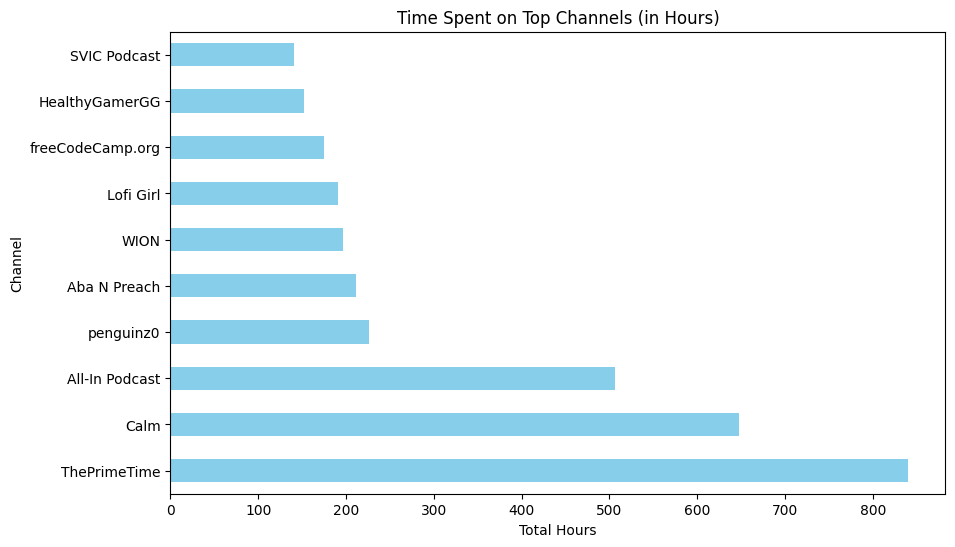

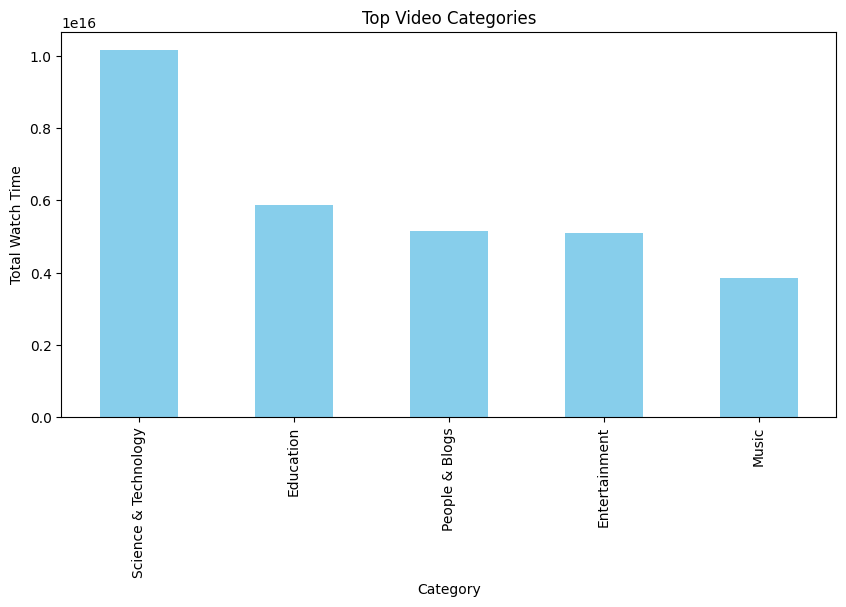

C:\Users\MoRevolution\AppData\Local\Temp\ipykernel_12468\2460677865.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table = pivot_table.applymap(lambda x: x.total_seconds() if pd.notnull(x) else 0)


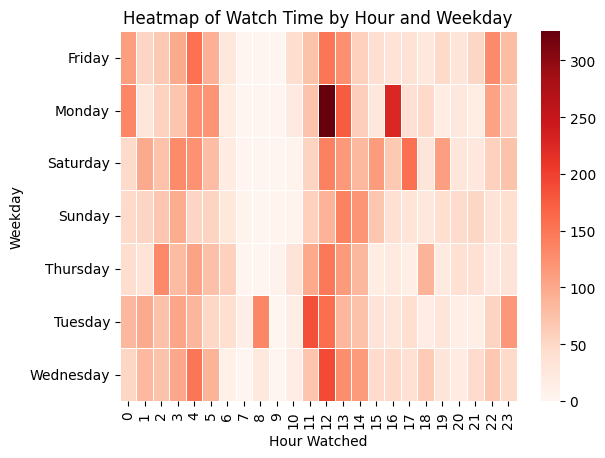

Total watch time: 439 days 13:31:36
Night owl vs Early bird - Night: 38 days 13:37:19, Morning: 156 days 20:42:10
Percentage of videos made for kids: 0.00%
Longest streak: date_watched
2023-06-22     1
2023-06-23    92
2023-06-24    84
2023-06-25    94
2023-06-26    60
              ..
2024-12-09    63
2024-12-10    38
2024-12-11    53
2024-12-12    55
2024-12-13    14
Name: count, Length: 534, dtype: int64

Top Channels:


channel
ThePrimeTime       35 days 00:41:04
Calm               27 days 00:00:00
All-In Podcast     21 days 01:56:44
penguinz0           9 days 10:07:58
Aba N Preach        8 days 19:41:07
WION                8 days 04:18:27
Lofi Girl           7 days 23:00:18
freeCodeCamp.org    7 days 06:35:08
HealthyGamerGG      6 days 08:11:07
SVIC Podcast        5 days 20:21:36
Name: duration, dtype: timedelta64[ns]


Category Watch Time:


category_title
Science & Technology   117 days 15:17:24
Education               67 days 20:50:53
People & Blogs          59 days 14:34:14
Entertainment           59 days 01:10:00
Music                   44 days 12:12:33
Name: duration, dtype: timedelta64[ns]


Most Liked Videos:


,video_id,channel,like_count
37179,9btQkaci6kA,Zach King,23664600
35489,--XugglC6EU,CowPhobia86,23334369
30135,CAOY8EKH1qU,MrBeast,21350024
16910,VH0pKx9gDpA,Eidan Sanker / Don’t Touch My Car,18017077
17179,8dWLclwtOpo,CursorGemink,17916944
28894,jNQXAC9IVRw,jawed,17149607
37924,spPo80dPUwI,USA TODAY,16551122
18371,8heTV_n4u9I,Tricksters,15924490
33031,0wobqw589l0,Goat Daddy's,15779425
33000,QOoepSo3ntM,Дом Зайца,15214021



Most Commented Videos:


,video_id,channel,comment_count
28894,jNQXAC9IVRw,jawed,10377120
23420,QdBZY2fkU-0,Rockstar Games,945955
28895,epgXuMB1sF8,DelhiTheCat,563889
23028,7PIMiDcwNvc,PewDiePie,506102
679,V1bFr2SWP1I,Mountain Apple Company Inc,422197
37924,spPo80dPUwI,USA TODAY,383388
1649,Gs069dndIYk,EarthWindandFireVEVO,351800
1650,Gs069dndIYk,EarthWindandFireVEVO,351800
7180,Gs069dndIYk,EarthWindandFireVEVO,351800
7181,Gs069dndIYk,EarthWindandFireVEVO,351800



Most Popular Videos:


,video_id,channel,view_count
37106,oyEuk8j8imI,JustinBieberVEVO,1761119010
679,V1bFr2SWP1I,Mountain Apple Company Inc,1463419135
37179,9btQkaci6kA,Zach King,985932062
14198,iX-QaNzd-0Y,Milky Chance Official,978197443
3764,CgyqK8_Wgsc,Mischievous Elephant,849949920
1649,Gs069dndIYk,EarthWindandFireVEVO,778583836
1650,Gs069dndIYk,EarthWindandFireVEVO,778583836
7180,Gs069dndIYk,EarthWindandFireVEVO,778583836
7181,Gs069dndIYk,EarthWindandFireVEVO,778583836
35489,--XugglC6EU,CowPhobia86,756323569



Longest Video:


,video_id,channel,duration
20938,nKOSkn6e39A,WION,8 days 04:18:27



Top Videos by Duration:


,video_id,channel,duration
20938,nKOSkn6e39A,WION,8 days 04:18:27
13727,Z-qo1DCvCT0,Lofi Girl,7 days 23:00:08
26215,LfaMVlDaQ24,freeCodeCamp.org,1 days 01:51:23
21776,Z_ikDlimN6A,Daniel Bourke,1 days 01:36:58
31327,8mAITcNt710,freeCodeCamp.org,1 days 00:51:37
30632,a3Aep-SygUA,NeetCode,1 days 00:17:16
4638,jyj9nfNYSfw,Rain Sound Natural,0 days 23:39:59
21880,rqGNDT_utao,Jordan Bown,0 days 18:30:33
26512,BpPEoZW5IiY,freeCodeCamp.org,0 days 13:59:10
27859,pkYVOmU3MgA,freeCodeCamp.org,0 days 12:30:50



Binge Creator:
channel
WION   8 days 04:18:27
Name: duration, dtype: timedelta64[ns]


In [ ]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_channels_hours = top_channels.dt.total_seconds() / 3600

# Plot as a horizontal bar chart
top_channels_hours.plot(kind='barh', title="Time Spent on Top Channels (in Hours)", color='skyblue', figsize=(10, 6))
plt.xlabel("Total Hours")
plt.ylabel("Channel")
plt.show()

category_watch_time.plot(kind='bar', title="Top Video Categories", color='skyblue', figsize=(10, 5))
plt.xlabel("Category")
plt.ylabel("Total Watch Time")
plt.show()

watch_by_hour.plot(kind='bar', title="Watch Time by Hour")

video_df['weekday'] = video_df['time_watched'].dt.day_name()
pivot_table = video_df.pivot_table(index='weekday', columns='hour_watched', values='duration', aggfunc='sum')

# Convert duration to total seconds for plotting
pivot_table = pivot_table.applymap(lambda x: x.total_seconds() if pd.notnull(x) else 0)

# Normalize the data for better visualization
pivot_table = pivot_table / 3600  # Convert seconds to hours

# Create a custom color palette
cmap = sns.color_palette("Reds", as_cmap=True)

sns.heatmap(pivot_table, cmap=cmap, linewidths=0.5)
plt.title("Heatmap of Watch Time by Hour and Weekday")
plt.xlabel("Hour Watched")
plt.ylabel("Weekday")
plt.show()

# Print summary stats
# print(f"Total watch time: {total_watch_time}")
# print(f"Top 10 Channels:\n{top_channels}")
# print(f"Top 5 Categories:\n{category_watch_time}")
# print(f"Most liked videos:\n{most_liked}")
# print(f"Most commented videos:\n{most_commented}")
# print(f"Most popular videos (global):\n{most_popular_videos}")
# print(f"Longest video watched:\n{longest_video}")
# print(f"Night owl vs Early bird - Night: {night_watching}, Morning: {morning_watching}")
# print(f"Percentage of videos made for kids: {kids_percentage:.2f}%")
# print(f"Longest streak: {streaks}")
# print(binge_creator)
# print(top_videos)


print(f"Total watch time: {total_watch_time}")
print(f"Night owl vs Early bird - Night: {night_watching}, Morning: {morning_watching}")
print(f"Percentage of videos made for kids: {kids_percentage:.2f}%")
print(f"Longest streak: {streaks}")

# Display DataFrames with names

print("\nTop Channels:")
display(top_channels)

print("\nCategory Watch Time:")
display(category_watch_time)

print("\nMost Liked Videos:")
display(most_liked)

print("\nMost Commented Videos:")
display(most_commented)

print("\nMost Popular Videos:")
display(most_popular_videos)

print("\nLongest Video:")
display(longest_video)

print("\nTop Videos by Duration:")
display(top_videos)

print("\nBinge Creator:")
print(binge_creator)

In [ ]:
# Convert total watch time to hours
total_watch_hours = total_watch_time.total_seconds() / 3600

# Calculate equivalents
movies_equivalent = total_watch_hours / 2  
books_equivalent = total_watch_hours / 10

print(f"You could have finished approximately {movies_equivalent:.1f} movies or {books_equivalent:.1f} books with the time you spent on YouTube!")


You could have finished approximately 5274.8 movies or 1055.0 books with the time you spent on YouTube!


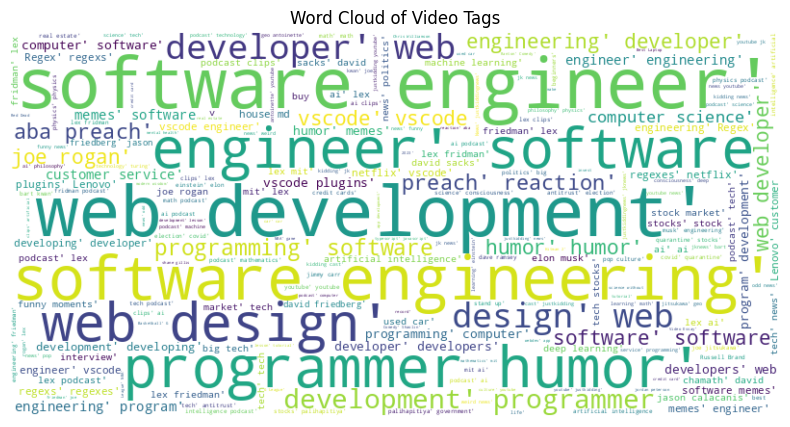

In [ ]:
all_tags = video_df['tags'].explode()
all_tags_str = ' '.join(all_tags.dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags_str)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Video Tags")
plt.show()